## Baseline Models

In [1]:
#Imports

import os
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [3]:
# Constants for color
GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [ ]:
# ENVIRONMENT
load_dotenv(override=True)
os.environ[''] = os.getenv()

In [4]:
# Enviroments
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')
os.environ['HUGGINGFACEHUB_API_TOKEN'] = os.getenv('HUGGINGFACEHUB_API_TOKEN')

#Logging to HuggingFace
hf_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hf_token,add_to_git_credential=True)

In [5]:
from items import Item
%matplotlib inline

In [7]:
# Loading the pickle files.
"""
Im using a small dataset, becuase of resouce crunch. And i want to 
go throught the entire coures. Once that is done, I can look into heavoer data
"""

'\nIm using a small dataset, becuase of resouce crunch. And i want to \ngo throught the entire coures. Once that is done, I can look into heavoer data\n'

In [8]:
with open('train.pkl','rb') as file:
    train = pickle.load(file)
with open('test.pkl','rb') as file:
    test = pickle.load(file)

In [9]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

KooKaStyle Long Wavy Drawstring Ponytail Extensions Synthetic Clip in Pony Tail Hairpieces 30 inch Curly Ponytail Extension for Women Girls (30 Inch, Golden Brown Mix Bleach Blonde)
ponytail extensions 💞 Ponytail Features This ponytail adopt the comfortable and breathable inner net design,and no irritation to the skin.No knots,no tangles,nice and thick and the curls are soft and bouncy.Save time easy to wear Reusable. 💓 Big beautiful Drawstring Ponytail Extension The new design of our hair is multi-layered,so the ponytail looks long and

Price is $16.00


In [20]:
# Evaluating model

class Tester:

    def __init__(self, predictor, title=None, data=test, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_"," ")
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error <40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self,i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(truth-guess)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error,truth)
        title = datapoint.title if len(datapoint.title) <=40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")


    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12,8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0,max_val],[0,max_val], color="deepskyblue",lw=2,alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel("Ground Truth")
        plt.ylabel("Model Estimate")
        plt.xlim(0,max_val)
        plt.ylim(0,max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors)/self.size
        rmsle = math.sqrt(sum(self.sles)/self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls,function):
        cls(function).run()

In [21]:
#Basic Random Pricer
def random_pricer(item):
    return random.randrange(1,1000)

1: Guess: $655.00 Truth: $500.00 Error: $155.00 SLE: 0.07 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $115.00 Truth: $9.79 Error: $105.21 SLE: 5.64 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $26.00 Truth: $29.99 Error: $3.99 SLE: 0.02 Item: Abosorbent wristbands and matching headb...
4: Guess: $760.00 Truth: $8.49 Error: $751.51 SLE: 19.22 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $282.00 Truth: $7.99 Error: $274.01 SLE: 11.90 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $251.00 Truth: $31.46 Error: $219.54 SLE: 4.20 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $229.00 Truth: $16.72 Error: $212.28 SLE: 6.57 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $143.00 Truth: $29.99 Error: $113.01 SLE: 2.36 Item: Beaver Chew / 6 cans
9: Guess: $755.00 Truth: $9.97 Error: $745.03 SLE: 17.92 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $105.00 Truth: $9.97 Error: $95.03 SLE: 5.15 Item: R

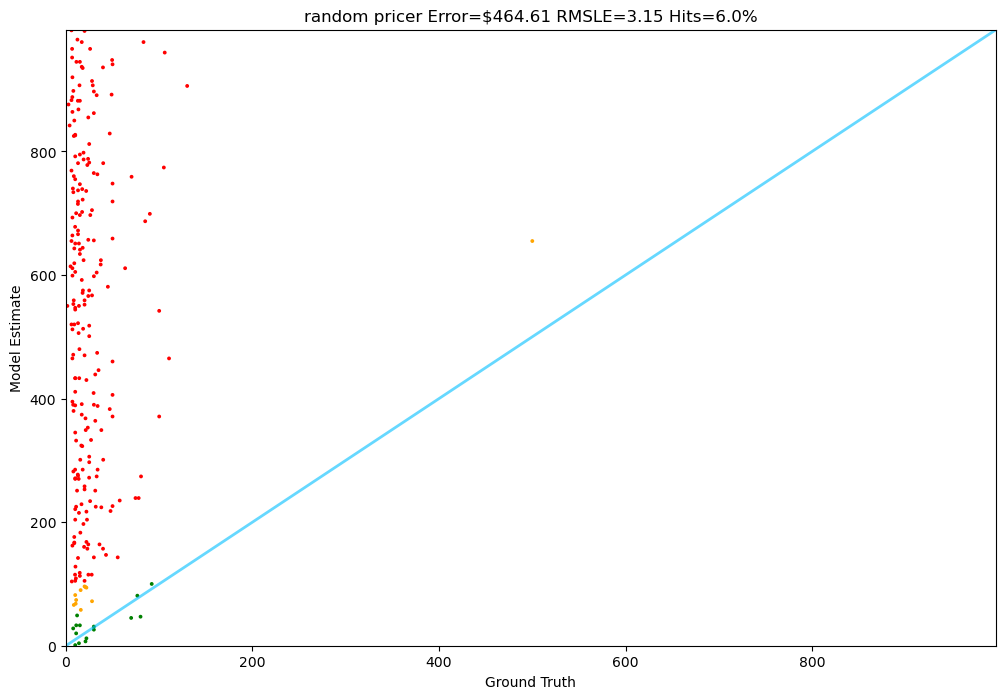

In [22]:
#Performance with random pricer.
random.seed(42)
Tester.test(random_pricer)

In [24]:
train[0].details

'{"Material": "Synthetic", "Style": "Modern", "Brand": "KooKaStyle", "Age Range (Description)": "Adult", "Package Dimensions": "11.77 x 6.06 x 3.27 inches; 6.74 Ounces"}'

In [26]:
# Create a new "feature" and populate it with json parsed
# from the details dict
for item in train:
    item.features = json.loads(item.details)
for item in test:
    item.features = json.loads(item.details)


In [35]:
train[10].features.keys()

dict_keys(['Color', 'Age Range (Description)', 'Material', 'Number of Items', 'Brand', 'Package Dimensions', 'Item model number', 'Department', 'UPC', 'Manufacturer'])

In [30]:
# Common features inn training set
feature_count = Counter()
for item in train:
    for f in item.features.keys():
        feature_count[f]+=1

feature_count.most_common(40)

[('Brand', 3505),
 ('Manufacturer', 3129),
 ('UPC', 3055),
 ('Package Dimensions', 2496),
 ('Is Discontinued By Manufacturer', 2222),
 ('Item Form', 2153),
 ('Item model number', 1869),
 ('Product Dimensions', 1690),
 ('Color', 1150),
 ('Number of Items', 1095),
 ('Unit Count', 1065),
 ('Age Range (Description)', 1042),
 ('Scent', 835),
 ('Material', 820),
 ('Hair Type', 799),
 ('Skin Type', 731),
 ('Item Weight', 513),
 ('Material Feature', 482),
 ('Product Benefits', 473),
 ('Style', 471),
 ('Special Feature', 466),
 ('Finish Type', 457),
 ('Item Volume', 386),
 ('Liquid Volume', 321),
 ('Country of Origin', 319),
 ('Date First Available', 317),
 ('Department', 293),
 ('Item Dimensions LxWxH', 266),
 ('Number of Pieces', 253),
 ('Domestic Shipping', 248),
 ('International Shipping', 248),
 ('Size', 203),
 ('Package Information', 175),
 ('Use for', 152),
 ('Active Ingredients', 140),
 ('Shape', 128),
 ('Material Type Free', 124),
 ('Recommended Uses For Product', 118),
 ('Skin Tone', 

In [31]:
def get_weight(item):
    weight_str = item.features.get('Item Weight')
    if weight_str:
        parts = weight_str.split(' ')
        amount = float(parts[0])
        unit = parts[1].lower()
        if unit=="pounds":
            return amount
        elif unit=="ounces":
            return amount / 16
        elif unit=="grams":
            return amount / 453.592
        elif unit=="milligrams":
            return amount / 453592
        elif unit=="kilograms":
            return amount / 0.453592
        elif unit=="hundredths" and parts[2].lower()=="pounds":
            return amount / 100
        else:
            print(weight_str)
    return None

In [32]:
weights = [get_weight(t) for t in train]
weights = [w for w in weights if w]

In [33]:
averge_weight = sum(weights)/len(weights)
averge_weight

0.9136867691154341

In [34]:
def get_weight_with_default(item):
    weight = get_weight(item)
    return weight or averge_weight

I'm ttrying to make a linear regression model as done in the course.
As there are different products in this dataset. I'll try to find features that could be useful here.
In the course the instructor took weight, rank, text lenght,top brand. I'll do domething same.
I'll take brand,weight, scent

In [37]:
# Text length
def get_text_length(item):
    return len(item.test_prompt())


In [39]:
# Brands
brands = Counter()
for t in train:
    brand = t.features.get("Brand")
    if brand:
        brands[brand]+=1
brands.most_common(10)

[('Bath & Body Works', 34),
 ('IBD', 33),
 ('Orly', 24),
 ('Generic', 23),
 ('China Glaze', 20),
 ('KISS', 16),
 ('MoYo Natural Labs', 16),
 ('Estee Lauder', 15),
 ('Brrnoo', 14),
 ('NICKA K NEW YORK', 13)]

In [66]:
TOP_BRANDS = ['Bath & Body Works','IBD','Orly','Generic','China Glaze','KISS','MoYo Natural Labs','Estee Lauder']
def is_top_brand(item):
    brand = item.features.get("Brand")
    return brand and brand.lower() in TOP_BRANDS

In [67]:
# Manufacturer
manufacturers = Counter()
for t in train:
    manufacturer = t.features.get("Manufacturer")
    if manufacturer:
        manufacturers[manufacturer]+=1
manufacturers.most_common(10)

[('IBD Beauty', 32),
 ('VAGA', 24),
 ('Amazon', 21),
 ('American International Industries', 20),
 ('MoYo Natural Labs', 18),
 ('TMP', 13),
 ('Brrnoo', 12),
 ('Essie', 11),
 ('Liquid Latex Fashions', 11),
 ('Sparkle & Co.', 10)]

In [68]:
# Manufacturer
materials = Counter()
for t in train:
    material = t.features.get("Material")
    if material:
        materials[material]+=1
materials.most_common(10)

[('Synthetic', 122),
 ('Plastic', 79),
 ('Acrylic', 45),
 ('Metal', 44),
 ('Human Hair', 32),
 ('Stainless Steel', 29),
 ('Silicone', 27),
 ('Polyester', 21),
 ('Cotton', 20),
 ('Silk', 16)]

In [69]:
TOP_MATERIALS = [m[0] for m in materials.most_common(10)]
TOP_MATERIALS

['Synthetic',
 'Plastic',
 'Acrylic',
 'Metal',
 'Human Hair',
 'Stainless Steel',
 'Silicone',
 'Polyester',
 'Cotton',
 'Silk']

In [70]:
def is_top_material(item):
    material = item.features.get("Material")
    return material and material.lower() in TOP_MATERIALS

In [71]:
TOP_MANU = [m[0] for m in manufacturers.most_common(10)]
TOP_MANU

['IBD Beauty',
 'VAGA',
 'Amazon',
 'American International Industries',
 'MoYo Natural Labs',
 'TMP',
 'Brrnoo',
 'Essie',
 'Liquid Latex Fashions',
 'Sparkle & Co.']

In [72]:
def is_top_manufacturer(item):
    manu = item.features.get("Manufacturer")
    return manu and manu.lower() in TOP_MANU

In [73]:
# Manufacturer
scents = Counter()
for t in train:
    scent = t.features.get("Scent")
    if scent:
        scents[scent]+=1
scents.most_common(10)

[('Unscented', 93),
 ('Coconut', 41),
 ('Fresh', 35),
 ('Aloe Vera', 25),
 ('Aloe', 24),
 ('Lavender', 20),
 ('Citrus', 18),
 ('Rose', 18),
 ('Floral', 16),
 ('Vanilla', 14)]

In [74]:
TOP_SCENTS = [s[0] for s in scents.most_common(10)]
TOP_SCENTS

['Unscented',
 'Coconut',
 'Fresh',
 'Aloe Vera',
 'Aloe',
 'Lavender',
 'Citrus',
 'Rose',
 'Floral',
 'Vanilla']

In [75]:
def is_top_scent(item):
    scent = item.features.get("Scent")
    return scent and brand.lower() in TOP_SCENTS

In [81]:
def get_features(item):
    return{
        "weight":get_weight_with_default(item),
        "scent":1 if is_top_scent(item) else 0,
        "brand":1 if is_top_brand(item) else 0,
        "manufacturer":1 if is_top_manufacturer(item) else 0,
        "material":1 if is_top_material(item) else 0,
        "text_lenght":get_text_length(item)
    }

In [82]:
get_features(train[0])

{'weight': 0.9136867691154341,
 'scent': 0,
 'brand': 0,
 'manufacturer': 0,
 'material': 0,
 'text_lenght': 602}

In [83]:
# Convert the features into df
def list_to_df(items):
    features = [get_features(item) for item in items]
    df = pd.DataFrame(features)
    df['price'] = [item.price for item in items]
    return df

train_df = list_to_df(train)
test_df = list_to_df(test)

In [85]:
train_df.columns

Index(['weight', 'scent', 'brand', 'manufacturer', 'material', 'text_lenght',
       'price'],
      dtype='object')

In [86]:
## Traditional Linear Regression
np.random.seed(42)

features_cols = ['weight', 'scent', 'brand', 'manufacturer', 'material', 'text_lenght']

X_train = train_df[features_cols]
y_train = train_df['price']
X_test = test_df[features_cols]
y_test = test_df['price']

# Linear gression model
model = LinearRegression()
model.fit(X_train,y_train)

for feature,coef in zip(features_cols, model.coef_):
    print(f"{feature}:{coef}")
print(f"Intercept: {model.intercept_}")

# Prediction
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test,y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 score: {r2}")

weight:8.166559632234819
scent:0.0
brand:0.0
manufacturer:0.0
material:0.0
text_lenght:-0.001175918746419357
Intercept: 19.67086042761091
Mean Squared Error: 1433.1501435240482
R2 score: 0.0013940016854269155


In [87]:
# predict price
def linear_regression_pricer(item):
    features = get_features(item)
    features_df = pd.DataFrame([features])
    return model.predict(features_df)[0]

1: Guess: $26.40 Truth: $500.00 Error: $473.60 SLE: 8.45 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $19.23 Truth: $9.79 Error: $9.44 SLE: 0.39 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $26.42 Truth: $29.99 Error: $3.57 SLE: 0.01 Item: Abosorbent wristbands and matching headb...
4: Guess: $26.54 Truth: $8.49 Error: $18.05 SLE: 1.13 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $26.34 Truth: $7.99 Error: $18.35 SLE: 1.24 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $26.51 Truth: $31.46 Error: $4.95 SLE: 0.03 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $26.45 Truth: $16.72 Error: $9.73 SLE: 0.19 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $26.49 Truth: $29.99 Error: $3.50 SLE: 0.01 Item: Beaver Chew / 6 cans
9: Guess: $26.32 Truth: $9.97 Error: $16.35 SLE: 0.83 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $19.81 Truth: $9.97 Error: $9.84 SLE: 0.41 Item: REFINE - Germany - Pedicu

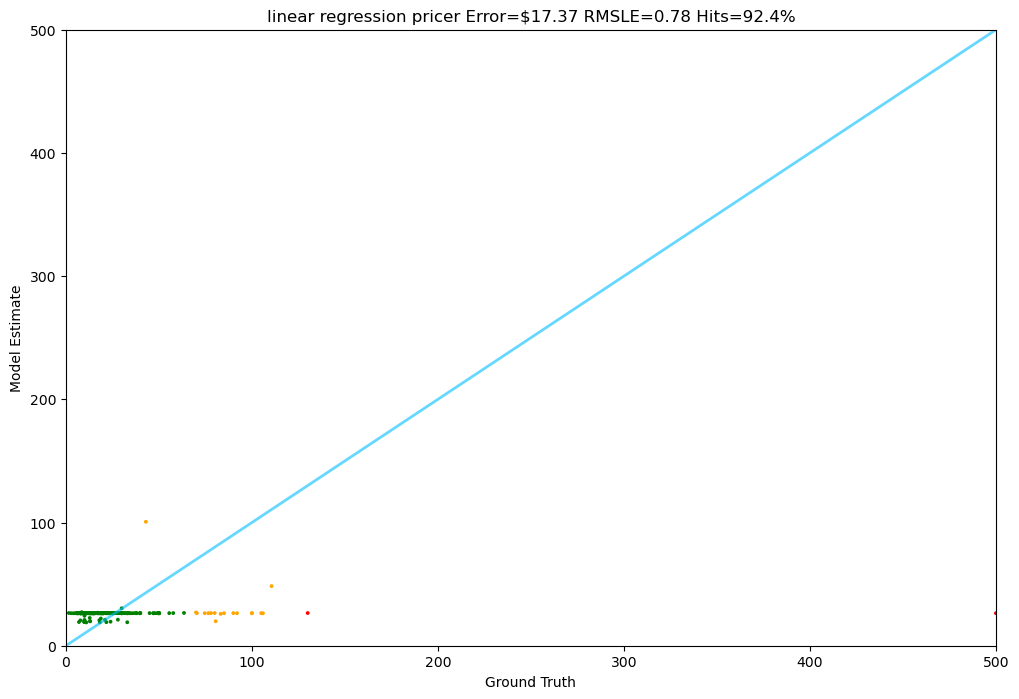

In [95]:
Tester.test(linear_regression_pricer)

In [96]:
# 92% Correct !!!

Bag of Words Pricer

In [97]:
prices = np.array([float(item.price) for item in train])
documents = [item.test_prompt() for item in train]

In [99]:
# Countvectoriser for BoW Model
np.random.seed(42)
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(documents)
regressor = LinearRegression()
regressor.fit(X,prices)

LinearRegression()

In [103]:
def bow_lr_pricer(item):
    x = vectorizer.transform([item.test_prompt()])
    return max(regressor.predict(x)[0],0)

1: Guess: $46.65 Truth: $500.00 Error: $453.35 SLE: 5.54 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $40.94 Truth: $9.79 Error: $31.15 SLE: 1.84 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $0.00 Truth: $29.99 Error: $29.99 SLE: 11.79 Item: Abosorbent wristbands and matching headb...
4: Guess: $0.00 Truth: $8.49 Error: $8.49 SLE: 5.06 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $31.65 Truth: $7.99 Error: $23.66 SLE: 1.66 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $46.28 Truth: $31.46 Error: $14.82 SLE: 0.14 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $31.54 Truth: $16.72 Error: $14.82 SLE: 0.37 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $21.09 Truth: $29.99 Error: $8.90 SLE: 0.11 Item: Beaver Chew / 6 cans
9: Guess: $32.80 Truth: $9.97 Error: $22.83 SLE: 1.27 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $71.75 Truth: $9.97 Error: $61.78 SLE: 3.58 Item: REFINE - Germany - Ped

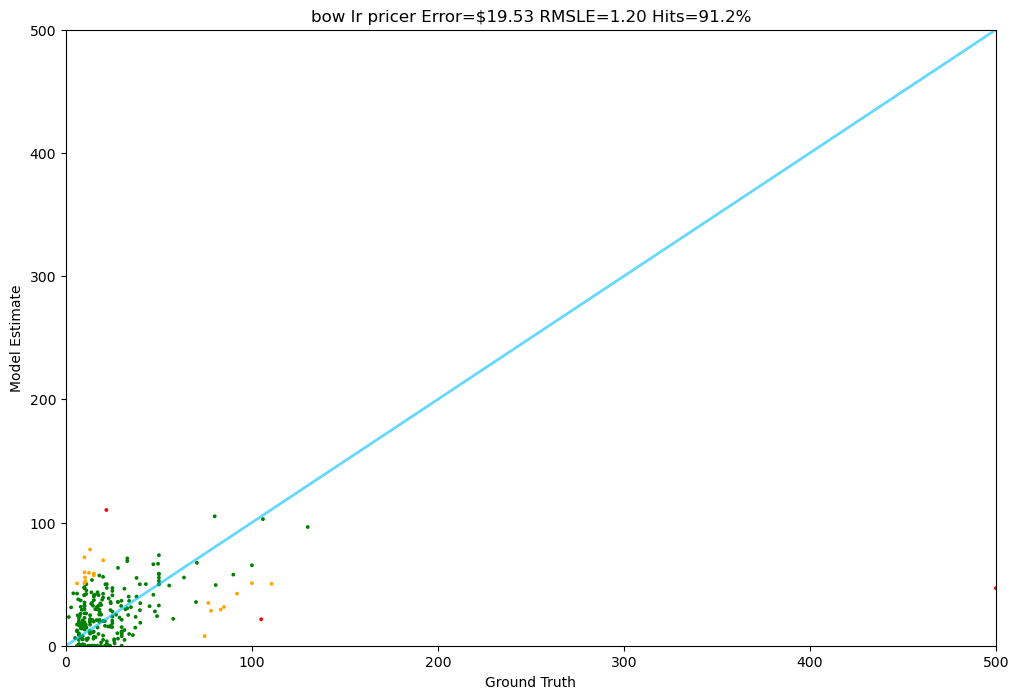

In [104]:
Tester.test(bow_lr_pricer)

Word2Vec using the gensim library

In [105]:
np.random.seed(42)
processed_docs = [simple_preprocess(doc) for doc in documents]
w2v_model = Word2Vec(sentences=processed_docs, vector_size=400, window=5, min_count=1)


In [106]:
def document_vector(doc):
    doc_words = simple_preprocess(doc)
    word_vectors = [w2v_model.wv[word] for word in doc_words if word in w2v_model.wv]
    return np.mean(word_vectors,axis=0) if word_vectors else np.zeros(w2v_model.vector_size)

X_w2v = np.array([document_vector(doc) for doc in documents])


In [107]:
word2vec_lr_regressor = LinearRegression()
word2vec_lr_regressor.fit(X_w2v, prices)

LinearRegression()

In [108]:
def word2vec_lr_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, word2vec_lr_regressor.predict([doc_vector])[0])

1: Guess: $50.74 Truth: $500.00 Error: $449.26 SLE: 5.15 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $25.26 Truth: $9.79 Error: $15.47 SLE: 0.79 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $14.32 Truth: $29.99 Error: $15.67 SLE: 0.50 Item: Abosorbent wristbands and matching headb...
4: Guess: $0.00 Truth: $8.49 Error: $8.49 SLE: 5.06 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $16.45 Truth: $7.99 Error: $8.46 SLE: 0.44 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $23.93 Truth: $31.46 Error: $7.53 SLE: 0.07 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $32.81 Truth: $16.72 Error: $16.09 SLE: 0.42 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $26.81 Truth: $29.99 Error: $3.18 SLE: 0.01 Item: Beaver Chew / 6 cans
9: Guess: $13.24 Truth: $9.97 Error: $3.27 SLE: 0.07 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $27.98 Truth: $9.97 Error: $18.01 SLE: 0.94 Item: REFINE - Germany - Pedicu

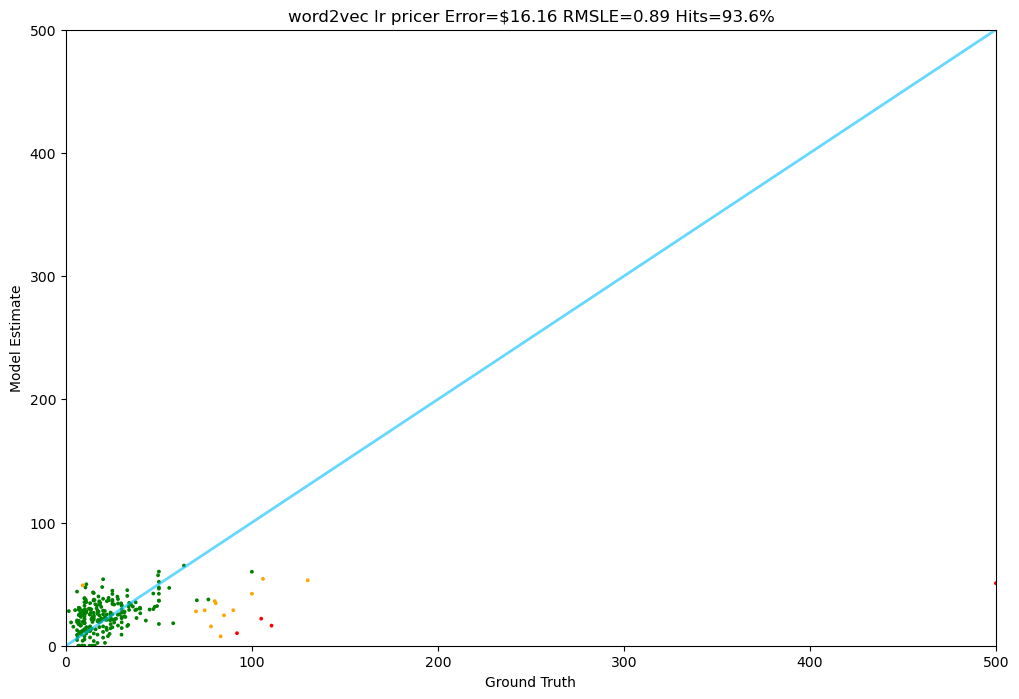

In [109]:
Tester.test(word2vec_lr_pricer)

Spport VEctors

In [110]:
np.random.seed(42)
svr_regressor = LinearSVR()
svr_regressor.fit(X_w2v, prices)

LinearSVR()

In [113]:
def svr_pricer(item):
    np.random.seed(42)
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(float(svr_regressor.predict([doc_vector])[0]),0)

1: Guess: $38.47 Truth: $500.00 Error: $461.53 SLE: 6.46 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $14.71 Truth: $9.79 Error: $4.92 SLE: 0.14 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $13.36 Truth: $29.99 Error: $16.63 SLE: 0.59 Item: Abosorbent wristbands and matching headb...
4: Guess: $6.07 Truth: $8.49 Error: $2.42 SLE: 0.09 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $14.59 Truth: $7.99 Error: $6.60 SLE: 0.30 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $21.16 Truth: $31.46 Error: $10.30 SLE: 0.15 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $23.77 Truth: $16.72 Error: $7.05 SLE: 0.11 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $23.67 Truth: $29.99 Error: $6.32 SLE: 0.05 Item: Beaver Chew / 6 cans
9: Guess: $12.21 Truth: $9.97 Error: $2.24 SLE: 0.03 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $14.47 Truth: $9.97 Error: $4.50 SLE: 0.12 Item: REFINE - Germany - Pedicure

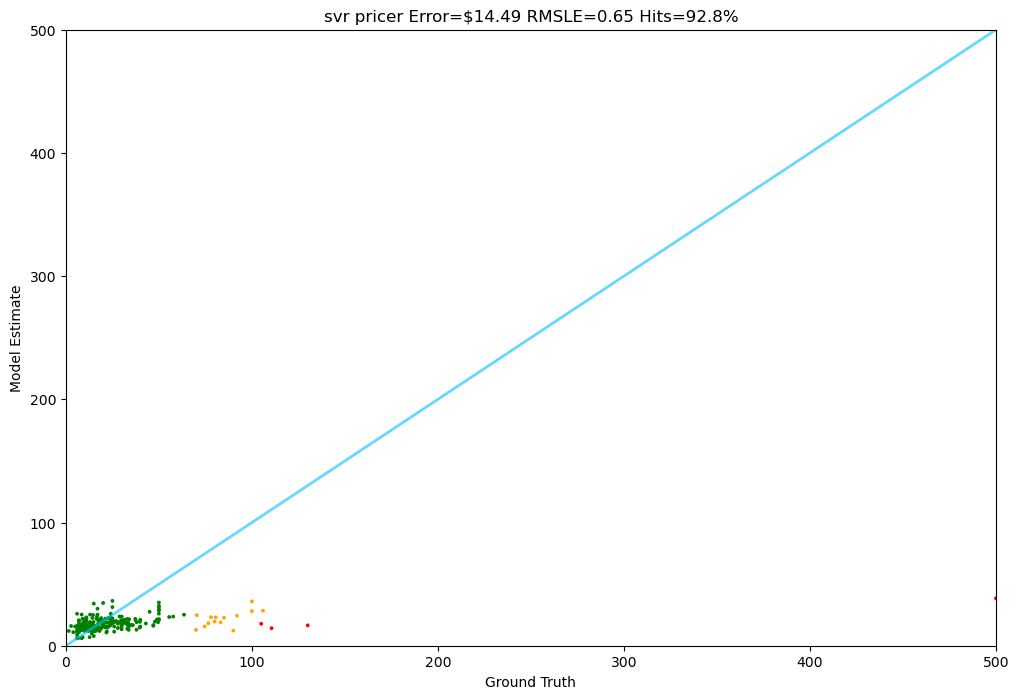

In [114]:
Tester.test(svr_pricer)

In [115]:
# And the powerful Random Forest regression

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf_model.fit(X_w2v, prices)

RandomForestRegressor(n_jobs=8, random_state=42)

In [116]:
def random_forest_pricer(item):
    doc = item.test_prompt()
    doc_vector = document_vector(doc)
    return max(0, rf_model.predict([doc_vector])[0])

1: Guess: $33.46 Truth: $500.00 Error: $466.54 SLE: 7.17 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $19.52 Truth: $9.79 Error: $9.73 SLE: 0.41 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $15.37 Truth: $29.99 Error: $14.62 SLE: 0.41 Item: Abosorbent wristbands and matching headb...
4: Guess: $10.38 Truth: $8.49 Error: $1.89 SLE: 0.03 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $21.41 Truth: $7.99 Error: $13.42 SLE: 0.83 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $19.18 Truth: $31.46 Error: $12.28 SLE: 0.23 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $30.95 Truth: $16.72 Error: $14.23 SLE: 0.35 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $26.40 Truth: $29.99 Error: $3.59 SLE: 0.02 Item: Beaver Chew / 6 cans
9: Guess: $26.79 Truth: $9.97 Error: $16.82 SLE: 0.86 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $17.28 Truth: $9.97 Error: $7.31 SLE: 0.26 Item: REFINE - Germany - Pedi

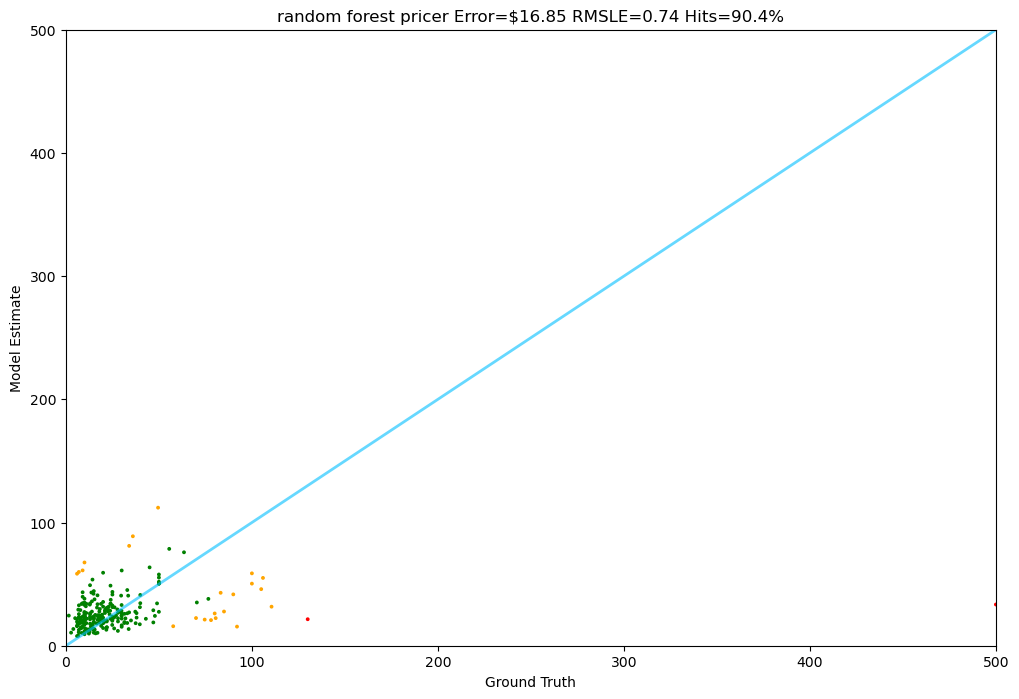

In [117]:
Tester.test(random_forest_pricer)

In [118]:
# LLMs

In [124]:
from testing import Tester
import google.generativeai
from openai import OpenAI

In [132]:
google_api_key = os.getenv('GOOGLE_API_KEY')


In [ ]:
openai = OpenAI()

In [125]:
def message_for(item):
    system_message = "You estimate prices of itmes. Reply only wiht the price, no explanation"
    user_prompt = item.test_prompt().replace("to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role":"system","content":system_message},
        {"role":"user","content":user_prompt},
        {"role":"assistant","content":"Price is $"}
    ]
    

In [126]:
message_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of itmes. Reply only wiht the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost ?\n\nAmazon.com $50 Gift Card - Pack of 10 Mini Envelopes\nGift Card is affixed inside a mini envelope Gift amount may not be printed on Gift Cards Gift Card has no fees and no expiration date No returns and no refunds on Gift Cards Gift Card is redeemable towards millions of items storewide at Amazon.com Scan and redeem any Gift Card with a mobile or tablet device via the Amazon App Free One-Day Shipping (where available) Customized gift message, if chosen at check-out, only appears on packing slip and not on the actual gift card or carrier Dimensions 4.53 x 4.02 x'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [129]:
# Cleaning the price form a string
import re
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [130]:
get_price("The price is roughly $ 99.99 becuase bla bla")

99.99

In [138]:
gemini_via_openai_client = OpenAI(
    api_key=google_api_key, 
    base_url="https://generativelanguage.googleapis.com/v1beta/openai/"
)

def gemini_model(item):
    response = gemini_via_openai_client.chat.completions.create(
        model = "gemini-2.0-flash",
        messages= message_for(item),
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)
    

In [141]:
Tester.test(gemini_model,test)

1: Guess: $500.00 Truth: $500.00 Error: $0.00 SLE: 0.00 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $8.99 Truth: $9.79 Error: $0.80 SLE: 0.01 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $12.00 Truth: $29.99 Error: $17.99 SLE: 0.75 Item: Abosorbent wristbands and matching headb...
4: Guess: $9.99 Truth: $8.49 Error: $1.50 SLE: 0.02 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $7.99 Truth: $7.99 Error: $0.00 SLE: 0.00 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $28.00 Truth: $31.46 Error: $3.46 SLE: 0.01 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $15.00 Truth: $16.72 Error: $1.72 SLE: 0.01 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $29.99 Truth: $29.99 Error: $0.00 SLE: 0.00 Item: Beaver Chew / 6 cans
9: Guess: $7.99 Truth: $9.97 Error: $1.98 SLE: 0.04 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $17.99 Truth: $9.97 Error: $8.02 SLE: 0.30 Item: REFINE - Germany - Pedicure Corn

RateLimitError: Error code: 429 - [{'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '25s'}]}}]

My current plan allows 10 RPM, that is 10 requests per mintue to Gemini. Incorporating sleep so that, the function doesn't send requests too fast.

In [142]:


import time

def test_with_rate_limit(cls, function, data, rpm_limit=10):
    instance = cls(function, data)
    delay = 60 / rpm_limit  # seconds between requests

    instance.error = 0
    for i in range(instance.size):
        try:
            instance.run_datapoint(i)
        except Exception as e:
            print(f"Error at index {i}: {e}")
            instance.error += 1
        time.sleep(delay)
    instance.report()


1: Guess: $500.00 Truth: $500.00 Error: $0.00 SLE: 0.00 Item: Amazon.com $50 Gift Card - Pack of 10 Mi...
2: Guess: $12.00 Truth: $9.79 Error: $2.21 SLE: 0.03 Item: Fashion Adjustable Black Leather Cotton ...
3: Guess: $19.99 Truth: $29.99 Error: $10.00 SLE: 0.15 Item: Abosorbent wristbands and matching headb...
4: Guess: $12.99 Truth: $8.49 Error: $4.50 SLE: 0.15 Item: Beauticom 4 Pcs Nail Art Bubble Bath Spa...
5: Guess: $7.99 Truth: $7.99 Error: $0.00 SLE: 0.00 Item: DIY Kit Creations: Clear Lip Gloss Tube ...
6: Guess: $28.00 Truth: $31.46 Error: $3.46 SLE: 0.01 Item: K I.C.O.N. I.C.O.N. India Curl Cream, Wa...
7: Guess: $19.99 Truth: $16.72 Error: $3.27 SLE: 0.03 Item: Salon pHactor Moisturizing Conditioner 1...
8: Guess: $29.99 Truth: $29.99 Error: $0.00 SLE: 0.00 Item: Beaver Chew / 6 cans
9: Guess: $8.99 Truth: $9.97 Error: $0.98 SLE: 0.01 Item: Harzara Professional Pet Finger Toothbru...
10: Guess: $15.00 Truth: $9.97 Error: $5.03 SLE: 0.14 Item: REFINE - Germany - Pedicure Co

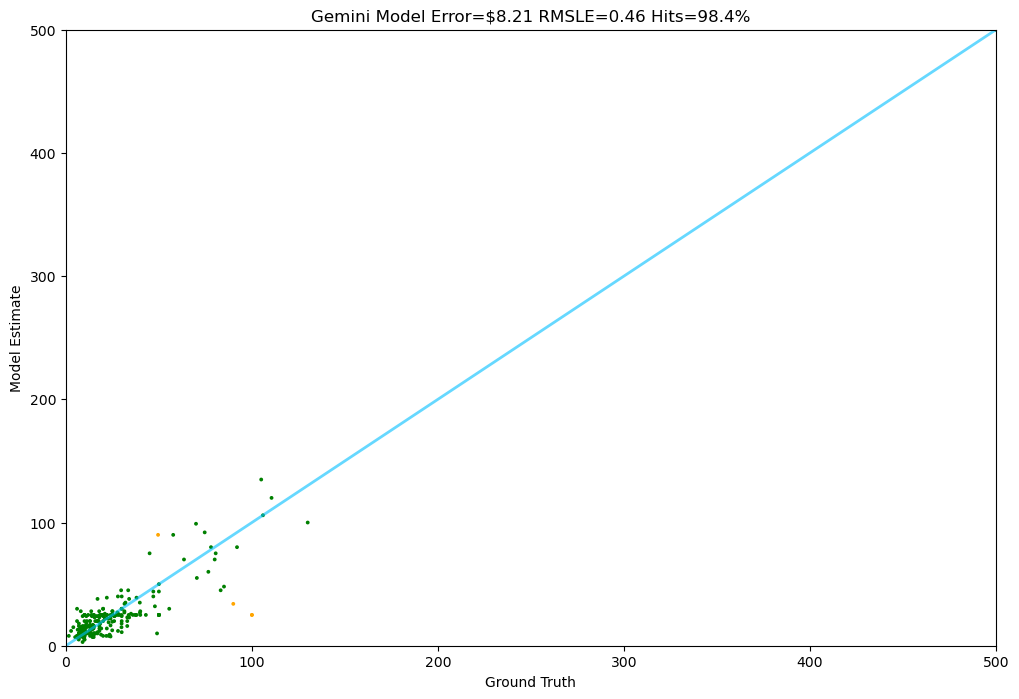

In [143]:
test_with_rate_limit(Tester, gemini_model, test, rpm_limit=10)


In [144]:
# 98% Already !!